>**Alumnos**: *Adrián Ogáyar Sanchez y Arturo Barbero Pérez*

>**Grupo**: *11*

***

# ENTRENAMIENTO DE REDES NEURONALES

Importamos las librerías que van a ser necesarias durante el desarrollo de la práctica: La librería **displayData** es necesaría para poder hacer el graficado de los números contenidos en la matriz de datos. **NumPy** es la librería que nos permite realizar calculos entre matrices y vectores de manera de más eficiente gracias a la vectorización. Importamos además **loadmat** que se va a encargar de obtener los datos del fichero mat. Por último, utilizamos **Optimize** de SciPy, que nos permite obtener el vector θ optimizado para cada clase.

In [1]:
from scipy.io import loadmat
from displayData import displayData
import numpy as np
import scipy.optimize as opt

## FUNCIÓN DE COSTE

El conjunto de datos utilizados para esta práctica es el mismo que el de la práctica 3. Tenemos una matriz de orden 5000x400 donde cada fila contiene un vector de 400 elementos que representa una imagen. Esta imagen en realidad es una matriz de 20x20 pixeles, pero se ha desplegado para poder operar con esta matriz de una manera óptima.
El vector *y* contiene 5000 componentes que representan las etiquetas de cada ejemplo de entrenamiento. El "0" se ha representado como un "10", manteniendo las etiquetas naturales del "1" al "9" para el resto de números.

In [2]:
data = loadmat('ex4data1.mat')

# se pueden consultar las claves con data.keys()
y = data['y']
X = data['X']
# almacena los datos leídos en X, y

print("Forma de X: " + str(X.shape))
print("Forma de y: " + str(y.shape))

Forma de X: (5000, 400)
Forma de y: (5000, 1)


Para ver que los datos se han cargado correctamente podemos elegir 100 imagenes aleatoriamente de la matriz de datos y obtener una muestra de ellos mediante la función *displayData*

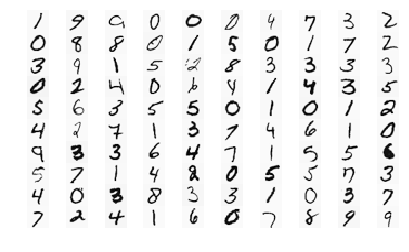

In [3]:
sample = np.random.choice(X.shape[0], 100)
fix, ax = displayData(X[sample, :])

La red neuronal que vamos a utilizar tiene una estructura formada por tres capas, con 400 unidades en la capa de entrada, 25 en la oculta y 10 en la de salida.
El fichero *ex4weights.mat* contiene las matrices $\theta$ que podremos usar para comprobar si se realiza de manera correcta el cálculo del coste. 

In [4]:
weights = loadmat("ex4weights.mat")
theta1, theta2 = weights["Theta1"], weights["Theta2"]

print("Forma de theta1: " + str(theta1.shape))
print("Forma de theta2: " + str(theta2.shape))

Forma de theta1: (25, 401)
Forma de theta2: (10, 26)


Pasamos, por tanto, a definir la función que se encargue de calcular el coste.

Declaramos primero la función sigmoide:

In [5]:
g = lambda z: 1 / (1 + np.exp(-z))

En segundo lugar implementamos la función hipótesis que es la encargada de crear la red neuronal de 3 capas y devolver un resultado:

In [6]:
def h(theta, x):
    theta1, theta2 = theta
    
    #La matriz X son las unidades pertenecientes a la capa de entrada
    one = np.ones((len(x), 1))
    #Añadimos a la matriz X la columna de 1's para obtener las unidades de la capa 1
    a1 = np.hstack([one, x])
    
    #Obtenemos un resultado para las unidades de la capa oculta gracias a theta1
    a2 = g(a1.dot(theta1.T))
    #Añadimos la columna de 1's a la segunda capa
    a2 = np.hstack([one, a2])
    
    #Obtenemos un resultado para las unidades de la capa de salida gracias a theta2
    a3 = g(a2.dot(theta2.T)) 
    
    return a3

La función de coste viene dado por la siguiente expresión:


$$J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}[  -y^{(i)}_k  log((h_\theta(x^{(i)}))_k) - (1 - y^{(i)}_k) log(1 - (h_\theta(x^{(i)}))_k)  ] $$

La cual se puede definir de la siguiente manera:

In [7]:
def funCoste(theta, x, y, num_etiquetas):
    
    #Creamos la matriz yk de orden (5000, 10) que contiene una fila con todos los elementos
    # a 0 salvo uno a 1 que indica el número a clasificar
    yk = np.zeros((len(x), num_etiquetas))
    for k in range(1, num_etiquetas + 1):
        yaux = np.where(y == k, 1, 0)
        yk[:, k-1] = yaux.ravel()
       
    #Calculamos la formula
    yaux = (np.log( h(theta, x) ) * yk) + (np.log( 1 - h(theta, x) ) * (1-yk))

    return -1/len(x) * yaux.sum()

Para comprobar que el método funciona correctamente la probaremos con *num_etiquetas = 10*. El resultado obtenido debería estar entorno a: *0.287629*

In [8]:
funCoste((theta1,theta2), X, y, 10)

0.2876291651613189

A continuación añadimos a la función de coste el termino de regularización, expresado con la siguiente fórmula:

$$J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}[  -y^{(i)}_k · log((h_\theta(x^{(i)}))_k) - (1 - y^{(i)}_k)· log(1 - (h_\theta(x^{(i)}))_k)  ] + \frac{\lambda}{2m}[\sum_{j=1}^{25}\sum_{k=1}^{400}(\theta^{(1)}_{j,k})^{2} + \sum_{j=1}^{10}\sum_{k=1}^{25}(\theta^{(2)}_{j,k})^{2} ] $$

In [9]:
def funCosteReg(theta, x, y, num_etiquetas, lamb):
    theta1, theta2 = theta
    
    return ( funCoste(theta, X, y, 10) + (lamb/(2*len(X)))*((theta1**2).sum() + (theta2**2).sum()) )

Como podemos ver, aunque en la fórmula se hayan dado los límites explícitos de $\theta^{(1)}$ y $\theta^{(2)}$, en esta versión vectorizada sirve para cualquier tipo de theta, ya que no se utilizan bucles que operen hasta un límite determinado.

Para esta función el resultado (con *$\lambda$ = 1*) debería dar un valor aproximado a: *0.383770*

In [10]:
funCosteReg((theta1, theta2), X, y, 10, 1)

0.384487796242894

## CÁLCULO DEL GRADIENTE

Para esta parte de la práctica, vamos a implementar el algoritmo de retro-propagación para poder realizar el cálculo del gradiente. 
Implementamos una función auxiliar que calcula la derivada de la función sigmoide *g*:

In [11]:
dg = lambda z: g(z) * (1 - g(z))

A continuación, implementamos una función que se encargue de inicializar una matriz de pesos $\theta$ con valores aleatorios en un rango [$\in_{ini}, \in_{ini}$]. Utilizaremos el valor $\in_{ini}$ = 0.12 para la inicialización:

In [12]:
def pesosAleatorios(L_in, L_out):
    return np.random.uniform(-0.12, 0.12, (L_in, L_out))

### Retro-propagación

Para realizar todo esto definiremos una función que se encargue de calcular el coste y vector gradiente de la red neuronal, dados los siguientes parámetros

In [13]:
def backprop(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y, reg):
    
    theta1 = np.reshape ( params_rn [:num_ocultas * (num_entradas + 1)],
    (num_ocultas, (num_entradas + 1)) )
    
    theta2 = np.reshape ( params_rn [num_ocultas * (num_entradas + 1):],
    (num_etiquetas, (num_ocultas + 1)) )
    
    theta = (theta1, theta2)

Esta función devuelve una tupla, siendo el primer elemento el coste y el segundo el vector gradiente.